In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

from run_experiment import *

!pip3 install --user -U scipy

In [2]:
def UAR(gt, pred):
    gt = np.array(gt)
    pred = np.array(pred)
    acc = []
    for x in np.unique(gt):
        _m = gt == x
        acc.append((gt[_m] == pred[_m]).mean())
    return np.mean(acc) * 100

def ACC(gt, pred):
    gt = np.array(gt)
    pred = np.array(pred)
    return (gt == pred).mean() * 100


def significance_test(metric_fn, y_true, y_pred_a, y_pred_b, tries=1<<12, random_state=41, gt2=None):
    assert y_true.shape[0] == y_pred_a.shape[0] == y_pred_b.shape[0]

    metric_a = metric_fn(y_true, y_pred_a)
    metric_b = metric_fn(y_true, y_pred_b)
    benchmark = np.abs(metric_a - metric_b)  # observed difference

    if random_state is not None:
        np.random.seed(random_state)  # fixing seed for reproducability
    samples = np.zeros(tries)  # the distribution of differences
    for i in range(tries):
        msk = np.random.random(size=y_true.shape[0]) < 0.5

        y_pred_a_perm = y_pred_a.copy()
        y_pred_b_perm = y_pred_b.copy()

        y_pred_a_perm[msk] = y_pred_b[msk]
        y_pred_b_perm[msk] = y_pred_a[msk]

        samples[i] = np.abs(
            metric_fn(y_true, y_pred_a_perm) - metric_fn(y_true, y_pred_b_perm)
        )
    pvalue = 1 - np.mean(benchmark > samples)
    sig = sum([int(pvalue < level) for level in [0.05,  0.01]])
    if sig == 0:
        sig = '     '
    elif sig == 1:
        sig = "^*   "
    elif sig == 2:
        sig = "^{**}"
    return metric_a, metric_b, sig
    #return "$ %7.2f^%s $" % (metric_a, sig), ("$ %7.2f $" % metric_b)
    #return metric_a, metric_b, pvalue#, benchmark, samples.mean(), samples.std()
    
def build_row(tab, gt, bow, roberta, gpt3, gpt4):
    parts = []
    acc_bow, acc_chatgpt3, p_acc_bow = significance_test(ACC, gt, bow, gpt3)
    acc_roberta, acc_chatgpt3, p_acc_roberta = significance_test(ACC, gt, roberta, gpt3)
    acc_gpt4, acc_chatgpt3, p_acc_gpt4 = significance_test(ACC, gt, gpt4, gpt3)

    uar_bow, uar_chatgpt3, p_uar_bow = significance_test(UAR, gt, bow, gpt3)
    uar_roberta, uar_chatgpt3, p_uar_roberta = significance_test(UAR, gt, roberta, gpt3)
    uar_gpt4, uar_chatgpt3, p_uar_gpt4 = significance_test(UAR, gt, gpt4, gpt3)
    
    mxacc = np.max([acc_bow, acc_roberta, acc_gpt4, acc_chatgpt3])
    mxuar = np.max([uar_bow, uar_roberta, uar_gpt4, uar_chatgpt3])
    print("%s\nExamples %d\n  BoW  :  %.4f   %.4f\nRoBERTa:  %.4f   %.4f\n GPT3  :  %.4f   %.4f\n GPT4  :  %.4f   %.4f\n\n" % (
        tab, len(gt), acc_bow, uar_bow, acc_roberta, uar_roberta, acc_chatgpt3, uar_chatgpt3, acc_gpt4, uar_gpt4
    ))
    accs = [
        "$\\textbf{%5.2f}%s $" % (acc, p) if np.isclose(mxacc, acc) else "$        %5.2f%s $" % (acc, p)  
        for acc, p in zip([acc_chatgpt3, acc_bow, acc_roberta, acc_gpt4], ['  ', p_acc_bow, p_acc_roberta, p_acc_gpt4 ])
    ]
    
    uars = [
        "$\\textbf{%5.2f}%s $" % (uar, p) if np.isclose(mxuar, uar) else "$        %5.2f%s $" % (uar, p)  
        for uar, p in zip([uar_chatgpt3, uar_bow, uar_roberta, uar_gpt4], ['  ', p_uar_bow, p_uar_roberta, p_uar_gpt4 ])
    ]

    return "&   %s  \\\\" % "  &  ".join([tab.replace("_", " ").capitalize()] + accs + uars)
#         acc_chatgpt3, acc_bow, acc_roberta, acc_gpt4,
#         uar_chatgpt3, uar_bow, uar_roberta, uar_gpt4,
#     ])

In [3]:
ROOT = "/outputs/chatgpt_evaluations/iteration_3/results"

def load(path):
    with open(path.replace("results/", f"{ROOT}/")) as fl:
        return json.load(fl)

In [4]:
latex_table = []

# Engagement

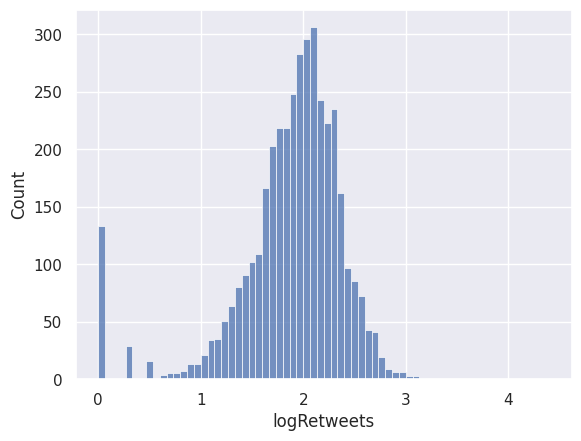

In [5]:
def engagement_plot():
    df = pd.read_csv("datasets/engagement measurement/TEDTalks.csv")
    df = df.sample(frac=1, random_state=41).reset_index()
    df['logRetweets'] = np.log10(df['retweetCount'] + 1)
    df = df[:4000]
    return sns.histplot(df['logRetweets'])

engagement_plot();

### Pair comparisons

In [6]:
def read_results(fil, *labels, df=None):
    if fil is not None:
        df = pd.read_csv(os.path.join("chatgpt-responses", fil), index_col=0)
    #print(df.columns)#, np.unique(df.ChatGPT))
    shp = df.shape
    assert len(labels) == 2
    _all = None
    for col in ["GPT3", "GPT4"]:
        __mskor = None
        for vals in labels:
            for a in vals:
                msk = (df[col] == a) | (df[col] == f"{a}.") | (df[col] == a.lower()) | (df[col] == f"{a}.".lower())
                if __mskor is None:
                    __mskor = msk
                else:
                    __mskor |= msk
        if _all is None:
            _all = __mskor
        else:
            _all &= __mskor
    df = df[_all]
    
    preds = []
    for col in ["GPT3", "GPT4"]:
        __mskor = None
        for a in labels[0]:
            msk = (df[col] == a) | (df[col] == f"{a}.") | (df[col] == a.lower()) | (df[col] == f"{a}.".lower())
            if __mskor is None:
                __mskor = msk
            else:
                __mskor |= msk
        preds.append(__mskor.astype(np.int32))

    return (df, shp[0]) + tuple(preds)
#     return (df[msks_or], shp[0]) + tuple(msks)

In [7]:
def engagement_fn():
    df = pd.read_csv("datasets/engagement measurement/TEDTalks.csv")
    df = df.sample(frac=1, random_state=41).reset_index()
    df['logRetweets'] = np.log10(df['retweetCount'] + 1)
    df = df[:4000]
    
    test_df, shp, gpt3_cmp, gpt4_cmp = read_results('engagement_pairs.csv', ["A"], ["B"])
    true = np.array(load(f"results/outputs_engagement_RoBERTa.json"))
    df['RoBERTa'] = np.array(load(f"results/predictions_engagement_RoBERTa.json"))[:, 0]
    df['BoW'] = np.array(load(f"results/predictions_engagement_BoW.json"))[:, 0]
    assert np.mean(np.abs(df["logRetweets"].values[test_df.idx_a.values] - np.log10(test_df['retweetCount_a'].values + 1))) < 1e-8
    assert np.mean(np.abs(df["logRetweets"].values[test_df.idx_b.values] - np.log10(test_df['retweetCount_b'].values + 1))) < 1e-8
    assert np.abs(true[:, 0, 0] - df['logRetweets'].values).mean() < 1e-8
    tab = "Engagement"
    roberta_cmp = (df["RoBERTa"].values[test_df.idx_a.values] > df["RoBERTa"].values[test_df.idx_b.values]).astype(np.int32)
    bow_cmp = (df["BoW"].values[test_df.idx_a.values] > df["BoW"].values[test_df.idx_b.values]).astype(np.int32)
    gt_cmp = (df.logRetweets.values[test_df.idx_a.values] > df.logRetweets.values[test_df.idx_b.values]).astype(np.int32)
    
    gt = (test_df['retweetCount_a'] > test_df['retweetCount_b']).astype(np.int32)
    assert (gt == gt_cmp).all()
    latex_table.append(build_row(tab, gt, bow_cmp, roberta_cmp, gpt3_cmp, gpt4_cmp))
    print(latex_table[-1])
    return test_df

engagement_fn()

Engagement
Examples 11996
  BoW  :  71.0153   71.0163
RoBERTa:  79.1847   79.1856
 GPT3  :  51.9173   51.8458
 GPT4  :  54.1514   53.7978


&   Engagement  &  $        51.92   $  &  $        71.02^{**} $  &  $\textbf{79.18}^{**} $  &  $        54.15^{**} $  &  $        51.85   $  &  $        71.02^{**} $  &  $\textbf{79.19}^{**} $  &  $        53.80^{**} $  \\


,idx_a,idx_b,content_a,content_b,retweetCount_a,retweetCount_b,GPT3,GPT4
0,3408,3406,This brain researcher studied her own stroke ....,@D4arkness2016 There are four! https://t.co/pq...,79,2,A,A
1,1963,1965,3 types of motivation that drive creative work...,Today's #TED: Ben Saunders: Why bother leaving...,321,47,B,A
2,3667,3916,@wickdchiq We hear your concern. She spoke at ...,@Maxim54619878 The totally average human who r...,0,0,A,B
3,1392,1892,12 stupendous talks for word-lovers: http://t....,"""Human beings are works in progress that mista...",212,188,A,B
4,332,2478,"""The biggest challenges and problems we face w...","""The brain abhors a vacuum."" How our memories ...",321,100,A,B
...,...,...,...,...,...,...,...,...
11991,2096,2993,"""As a child, I knew that stories were meant to...",@haleyvandyck Your talk was incredible today! ...,53,4,B,A
11992,1625,1623,TED believes that Black lives matter and that ...,A gut-wrenchingly honest look at living with d...,374,215,A,A
11993,1680,249,"""Creativity is as important in education as li...",We’re LIVE on #TEDConnects with Dr. Esther Cho...,769,12,B,B
11994,1974,166,This talk might leave you questioning the natu...,Why aren't you moving up at work? The career a...,189,48,B,B


# Well being

In [8]:
def well_being():
    for size, tab in zip([1000, 1000, 1000, 800, 1500], ['well_being_reddit', 'well_being_reddit_body', 'well_being_reddit_titles', 'well_being_twitter', 'well_being_twitter_full']):
        true = np.array(load(f"results/outputs_{tab}_RoBERTa.json"))
        df = pd.read_csv(f"chatgpt-responses/{tab}.csv", index_col=0)
        if 'body' in tab:
            col = 'body'
        elif 'reddit' in tab:
            col = 'title'
        else:
            col = 'text'
        df = filter_long_texts(df[:size], col)
        # print(df.shape, true.shape)
        assert np.abs(df.rename(columns={"labels":"label"})['label'].values - true[:, 0, 0]).mean() < 1e-8
        df['RoBERTa'] = np.array(load(f"results/predictions_{tab}_RoBERTa.json"))[:, 0]
        df['BoW'] = np.array(load(f"results/predictions_{tab}_BoW.json"))[:, 0]
        df, shp, gpt3_pred, gpt4_pred = read_results(None, ["Yes"], ["No"], df=df)

        gt = df.rename(columns={"labels":"label"})['label'].astype(np.int32)
        roberta_pred = (df['RoBERTa'].values > 0.5).astype(np.int32)
        bow_pred = (df['BoW'].values > 0.5).astype(np.int32)

        latex_table.append(build_row(tab[10:].strip(), gt, bow_pred, roberta_pred, gpt3_pred, gpt4_pred))
        print(latex_table[-1])
        print('---')
    return df

well_being()

_reddit
Examples 960
  BoW  :  30.8333   54.4174
RoBERTa:  94.5833   84.8777
 GPT3  :  75.7292   80.4564
 GPT4  :  90.1042   83.7296


&    reddit  &  $        75.73   $  &  $        30.83^{**} $  &  $\textbf{94.58}^{**} $  &  $        90.10^{**} $  &  $        80.46   $  &  $        54.42^{**} $  &  $\textbf{84.88}      $  &  $        83.73      $  \\
---
_reddit_body
Examples 929
  BoW  :  84.4995   68.8208
RoBERTa:  89.8816   86.1648
 GPT3  :  91.9268   84.4086
 GPT4  :  93.3262   78.6251


&    reddit body  &  $        91.93   $  &  $        84.50^{**} $  &  $        89.88      $  &  $\textbf{93.33}      $  &  $        84.41   $  &  $        68.82^{**} $  &  $\textbf{86.16}      $  &  $        78.63^{**} $  \\
---
_reddit_titles
Examples 985
  BoW  :  86.5990   85.6168
RoBERTa:  96.7513   96.6451
 GPT3  :  80.6091   80.0484
 GPT4  :  89.5431   89.7661


&    reddit titles  &  $        80.61   $  &  $        86.60^{**} $  &  $\textbf{96.75}^{**} $  &  $        89.54^{**} $  &  $    

,index,text,hashtags,labels,GPT3,GPT4,RoBERTa,BoW
0,393,Free yourself from the stress of anger and res...,[],1,Yes.,Yes,0.972885,0.984166
1,2535,Good night world sparkling heart family man wo...,"['Alessandro', 'Elena', 'Amori', 'Treasures', ...",0,No.,No,0.001246,0.030526
2,7558,Going Live with some more GTA V RP. What will ...,[],0,No.,No,0.006567,0.930452
3,2610,18 Useful Tips for Healthy Teeth And Gums tagf...,"['tagfire', 'lifestyle', 'healthcare', 'health...",0,No.,No,0.000005,0.125966
4,6743,Here's something different for you. mentalheal...,"['mentalhealth', 'stressmanagement', 'ambient'...",0,No.,Yes,0.004010,0.059737
...,...,...,...,...,...,...,...,...
1495,2127,Healthy habits promote quality sleep which is ...,"[""'health'"", ""'diabetes'"", ""'fit'"", ""'healthy'...",0,No.,No,0.035582,0.097194
1496,7458,Fields for Foxbridge day are absolutely brilli...,['excited'],0,No.,No,0.000234,0.060168
1497,443,Paris 2020. I still smile at this photo even t...,"[""'NewProfilePic'"", ""'staysafe'"", ""'stayhome'""...",1,No.,Yes,0.371444,0.875410
1498,5929,LamechLamarch25 Solidarity amazing SaveAllTheR...,"[""'SaveAllTheRainforests'"", ""'STOPSHELL'"", ""'E...",0,No.,No,0.960982,0.250854


# Emotion Intensity


The prompt used (once for each emotion, `{emotion}` is replaced each time)
```
You are an expert at emotion analysis.
Given a pair of text A and B from the user,
you will output which text expresses higher intensity of the {emotion} emotion.
Use the following format:
* You are only allowed to answer "A" or "B".
* Don't write an explanation of the answer.
* Don't write things like "My guess is...", or "I think ...". Just write A or B, but nothing else.

```


In [9]:
def emotions():
    for tab in ['joy', 'fear', 'anger', 'sadness']:
        df = pd.read_csv(f"datasets/intensity ranking/emotion intensity/test/{tab}.txt", delimiter="\t", names=["id", "text", "emotion", "score"])
        outs = np.array(load(f"results/outputs_{tab}_emotion_intensity_BoW.json"))
        assert np.mean(np.abs(df.score.values - outs[:, 0, 0])) < 1e-8
        df["RoBERTa"] = np.array(load(f"results/predictions_{tab}_emotion_intensity_RoBERTa.json"))[:, 0]
        df["BoW"] = np.array(load(f"results/predictions_{tab}_emotion_intensity_BoW.json"))[:, 0]

        test_df, shp, gpt3_cmp, gpt4_cmp = read_results(f'{tab}.csv', ["A"], ["B"])
        assert np.all(df.text.values[test_df.idx_a.values] == test_df.text_a)
        assert np.all(df.text.values[test_df.idx_b.values] == test_df.text_b)
        roberta_cmp = (df["RoBERTa"].values[test_df.idx_a.values] > df["RoBERTa"].values[test_df.idx_b.values]).astype(np.int32)
        bow_cmp = (df["BoW"].values[test_df.idx_a.values] > df["BoW"].values[test_df.idx_b.values]).astype(np.int32)
        gt_cmp = (df.score.values[test_df.idx_a.values] > df.score.values[test_df.idx_b.values]).astype(np.int32)

        gt = (test_df['score_a'] > test_df['score_b']).astype(np.int32)
        assert (gt == gt_cmp).all()

        latex_table.append(build_row(tab, gt, bow_cmp, roberta_cmp, gpt3_cmp, gpt4_cmp))
        print(latex_table[-1])
        print('---')
    return df

emotions()

joy
Examples 2098
  BoW  :  66.4919   66.5100
RoBERTa:  75.4051   75.4029
 GPT3  :  74.0705   74.2889
 GPT4  :  78.4557   78.6338


&   Joy  &  $        74.07   $  &  $        66.49^{**} $  &  $        75.41      $  &  $\textbf{78.46}^{**} $  &  $        74.29   $  &  $        66.51^{**} $  &  $        75.40      $  &  $\textbf{78.63}^{**} $  \\
---
fear
Examples 2922
  BoW  :  68.6516   68.6507
RoBERTa:  76.8309   76.8311
 GPT3  :  72.7584   72.8628
 GPT4  :  73.9562   74.0945


&   Fear  &  $        72.76   $  &  $        68.65^{**} $  &  $\textbf{76.83}^{**} $  &  $        73.96      $  &  $        72.86   $  &  $        68.65^{**} $  &  $\textbf{76.83}^{**} $  &  $        74.09      $  \\
---
anger
Examples 2224
  BoW  :  67.6259   67.6049
RoBERTa:  73.4712   73.4608
 GPT3  :  72.1223   72.0870
 GPT4  :  75.5845   75.4945


&   Anger  &  $        72.12   $  &  $        67.63^{**} $  &  $        73.47      $  &  $\textbf{75.58}^{**} $  &  $        72.09   $  &  $        67.60^{**} $

,id,text,emotion,score,RoBERTa,BoW
0,40860,My 2 teens sons just left in the car to get ha...,sadness,0.667,0.388516,0.585802
1,40861,My 2 teens sons just left in the car to get ha...,sadness,0.458,0.300646,0.432004
2,40862,HartRamsey'sUPLIFT If you're still discouraged...,sadness,0.396,0.360876,0.397999
3,40863,@AmontanaW I nearly dropped my phone into the ...,sadness,0.271,0.415862,0.422215
4,40864,Whenever I'm feeling sad I will listen to mons...,sadness,0.604,0.639444,0.716003
...,...,...,...,...,...,...
668,41528,Why does Candice constantly pout #GBBO ðŸ’„ðŸ˜’,sadness,0.396,0.407754,0.498224
669,41529,"@redBus_in #unhappy with #redbus CC, when I ta...",sadness,0.604,0.561787,0.523657
670,41530,"@AceOperative789 no pull him afew weeks ago, s...",sadness,0.479,0.310910,0.515773
671,41531,I'm buying art supplies and I'm debating how s...,sadness,0.375,0.346091,0.313963


# Personality

In [10]:
def personalities():
    traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
    data = read_personality('test')
    df = {t: np.array(data[1])[:, i] for i, t in enumerate(traits)}
    df['text'] = data[0]
    df = pd.DataFrame(df)

    outs = np.array(load(f"results/outputs_personality_BoW.json"))
    # assert np.mean(np.abs(df.score.values - outs[:, 0, 0])) < 1e-8
    for i, tab in enumerate(traits):
        df[f"RoBERTa"] = np.array(load(f"results/predictions_personality_RoBERTa.json"))[:, i]
        df[f"BoW"] = np.array(load(f"results/predictions_personality_BoW.json"))[:, i]
        test_df, shp, gpt3_cmp, gpt4_cmp = read_results(f'personality_{tab}.csv', ["A"], ["B"])
        assert np.all(df.text.values[test_df.idx_a.values] == test_df.text_a)
        assert np.all(df.text.values[test_df.idx_b.values] == test_df.text_b)
        roberta_cmp = (df["RoBERTa"].values[test_df.idx_a.values] > df["RoBERTa"].values[test_df.idx_b.values]).astype(np.int32)
        bow_cmp = (df["BoW"].values[test_df.idx_a.values] > df["BoW"].values[test_df.idx_b.values]).astype(np.int32)
        gt_cmp = (df[tab].values[test_df.idx_a.values] > df[tab].values[test_df.idx_b.values]).astype(np.int32)

        gt = (test_df[f'{tab}_a'] > test_df[f'{tab}_b']).astype(np.int32)
        assert (gt == gt_cmp).all()
        latex_table.append(build_row(tab, gt, bow_cmp, roberta_cmp, gpt3_cmp, gpt4_cmp))
        print(latex_table[-1])
        print('---')
    return df

personalities()

openness
Examples 5953
  BoW  :  58.3571   58.3579
RoBERTa:  60.5409   60.5619
 GPT3  :  50.1092   50.6038
 GPT4  :  54.7455   54.5876


&   Openness  &  $        50.11   $  &  $        58.36^{**} $  &  $\textbf{60.54}^{**} $  &  $        54.75^{**} $  &  $        50.60   $  &  $        58.36^{**} $  &  $\textbf{60.56}^{**} $  &  $        54.59^{**} $  \\
---
conscientiousness
Examples 5952
  BoW  :  56.7876   56.7820
RoBERTa:  61.5927   61.5950
 GPT3  :  55.5444   55.8419
 GPT4  :  57.4429   57.3327


&   Conscientiousness  &  $        55.54   $  &  $        56.79      $  &  $\textbf{61.59}^{**} $  &  $        57.44^*    $  &  $        55.84   $  &  $        56.78      $  &  $\textbf{61.59}^{**} $  &  $        57.33      $  \\
---
extraversion
Examples 5948
  BoW  :  56.5064   56.5077
RoBERTa:  59.0282   59.0195
 GPT3  :  53.5474   53.3846
 GPT4  :  55.9011   55.8998


&   Extraversion  &  $        53.55   $  &  $        56.51^{**} $  &  $\textbf{59.03}^{**} $  &  $        55.90^{**} 

,openness,conscientiousness,extraversion,agreeableness,neuroticism,text,RoBERTa,BoW
0,0.822222,0.669903,0.485981,0.681319,0.645833,"... Going nuts from another room, run in there...",0.475278,0.540604
1,0.655556,0.514563,0.616822,0.692308,0.593750,I've got a little bit to go but we need you th...,0.457885,0.574006
2,0.522222,0.524272,0.467290,0.560440,0.625000,"A video's quality over quantity, so everyone c...",0.532378,0.552091
3,0.400000,0.660194,0.411215,0.714286,0.458333,You really want to. That's made things a lot e...,0.555218,0.647303
4,0.411111,0.524272,0.317757,0.384615,0.437500,That's perfectly okay. The point isn't actuall...,0.542869,0.616673
...,...,...,...,...,...,...,...,...
1991,0.300000,0.135922,0.289720,0.208791,0.312500,"Du du du. No, that's not why I made this video...",0.559876,0.596579
1992,0.722222,0.572816,0.719626,0.670330,0.781250,They do it all the time.,0.414828,0.520885
1993,0.677778,0.446602,0.355140,0.472527,0.395833,Comfortable and I don't want anyone to feel un...,0.542214,0.579495
1994,0.622222,0.669903,0.467290,0.527473,0.645833,You're not giving yourself enough calories to ...,0.556595,0.621109


# Sentiment intensity

In [11]:
def sentiment_intensities():
    data = read_sentiment_ranking_microblogs("test")
    df = pd.DataFrame({"spans": data[0], "sentiment": data[1]})
    tab = "sentiment_microblogs"

    outs = np.array(load(f"results/outputs_sentiment_ranking_microblogs_RoBERTa.json"))[:, 0, 0]
    assert np.mean(np.abs(df.sentiment.values - outs)) < 1e-5

    df["RoBERTa"] = np.array(load(f"results/predictions_sentiment_ranking_microblogs_RoBERTa.json"))[:, 0]
    df["BoW"] = np.array(load(f"results/predictions_sentiment_ranking_microblogs_BoW.json"))[:, 0]
    df
    test_df, shp, gpt3_cmp, gpt4_cmp = read_results('sentiment_microblogs.csv', ["A"], ["B"])
    print(test_df.idx_a.max(), test_df.idx_b.max())
    test_df = test_df[(test_df.idx_a < df.shape[0]) & (test_df.idx_b < df.shape[0])]

    assert np.all(df.spans.values[test_df.idx_a.values] == test_df.spans_a)
    assert np.all(df.spans.values[test_df.idx_b.values] == test_df.spans_b)
    roberta_cmp = (df["RoBERTa"].values[test_df.idx_a.values] > df["RoBERTa"].values[test_df.idx_b.values]).astype(np.int32)
    bow_cmp = (df["BoW"].values[test_df.idx_a.values] > df["BoW"].values[test_df.idx_b.values]).astype(np.int32)
    gt_cmp = (df.sentiment.values[test_df.idx_a.values] > df.sentiment.values[test_df.idx_b.values]).astype(np.int32)

    gt = (test_df['sentiment_a'] > test_df['sentiment_b']).astype(np.int32)
    assert (gt == gt_cmp).all()

    latex_table.append(build_row(tab, gt, bow_cmp, roberta_cmp, gpt3_cmp, gpt4_cmp))
    print(latex_table[-1])
    print('---')
    return df

sentiment_intensities()

364 364
sentiment_microblogs
Examples 1075
  BoW  :  70.8837   70.8266
RoBERTa:  72.3721   72.4105
 GPT3  :  69.3023   68.6942
 GPT4  :  73.2093   73.0797


&   Sentiment microblogs  &  $        69.30   $  &  $        70.88      $  &  $        72.37      $  &  $\textbf{73.21}^{**} $  &  $        68.69   $  &  $        70.83      $  &  $        72.41^*    $  &  $\textbf{73.08}^{**} $  \\
---


,spans,sentiment,RoBERTa,BoW
0,looks primed poised to run too,0.400,-0.226472,0.211981
1,new HOD,0.432,0.453825,0.390131
2,Nice day rally!,0.529,0.537030,0.507975
3,new HOD with conviction keeping $570 on watch ...,0.529,0.332714,0.399209
4,then shorted it down.,-0.405,-0.439985,0.176595
...,...,...,...,...
360,Slips on Downgrade,-0.093,-0.403032,-0.435785
361,5-star analyst @brianwieser from Pivotal Resea...,0.561,0.357204,0.171257
362,see if they maintain 15% yield should be annou...,0.078,0.200502,0.191174
363,Announces Record #Esports Viewership,0.208,0.419580,0.290590


# Sarcasm


The prompt used:
```
You are an expert at sarcasm analysis.
Given a text by the user, estimate if the given text is sarcastic or not.
Use the following format:
* You are only allowed to answer "Yes" or "No".
* Don't write an explanation of the answer.
* Don't write things like "My guess is...", or "I think ...". Just write Yes or No, but nothing else.

```


tab = "sarcasm.csv"
df, shp, msk_a, msk_b = read_results(tab, ["Yes"], ["No"])
pred = msk_a.astype(np.int32)
gt = df['is_sarcastic'].astype(np.int32)
print("%30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, df.shape[0], shp - df.shape[0], ACC(gt, pred), UAR(gt, pred)))
df

In [12]:
def run_sarcasm():
    tab = "sarcasm.csv"
    df = pd.read_csv("chatgpt-responses/sarcasm.csv", index_col=0)
    true = np.array(load("results/outputs_sarcasm_RoBERTa.json"))
    assert np.mean(np.abs(df["is_sarcastic"].values - true[:, 0, 0])) < 1e-8
    df['RoBERTa'] = np.array(load("results/predictions_sarcasm_RoBERTa.json"))[:, 0]
    df['BoW'] = np.array(load("results/predictions_sarcasm_BoW.json"))[:, 0]
    df, shp, gpt3_pred, gpt4_pred = read_results(None, ["Yes"], ["No"], df=df)
    gt = df['is_sarcastic'].astype(np.int32)
    roberta_pred = (df["RoBERTa"] > 0.5).astype(np.int32)
    bow_pred = (df["BoW"] > 0.5).astype(np.int32)
    latex_table.append(build_row(tab[:-4].strip(), gt, bow_pred, roberta_pred, gpt3_pred, gpt4_pred))
    print(latex_table[-1])
    return df

run_sarcasm()

sarcasm
Examples 3983
  BoW  :  63.1434   66.2883
RoBERTa:  90.6603   90.6964
 GPT3  :  59.1263   56.8235
 GPT4  :  66.6583   69.4528


&   Sarcasm  &  $        59.13   $  &  $        63.14^{**} $  &  $\textbf{90.66}^{**} $  &  $        66.66^{**} $  &  $        56.82   $  &  $        66.29^{**} $  &  $\textbf{90.70}^{**} $  &  $        69.45^{**} $  \\


,index,article_link,headline,is_sarcastic,GPT3,GPT4,RoBERTa,BoW
0,3923,https://www.huffingtonpost.com/entry/lets-wish...,let's wish medicare and medicaid a happy birth...,0,No.,Yes,1.784492e-04,0.209161
1,25404,https://politics.theonion.com/clinton-credits-...,"clinton credits nevada victory to inescapable,...",1,Yes.,Yes,9.999926e-01,0.969197
2,3321,https://www.huffingtonpost.com/entry/cat-celeb...,"human throws her cat a snazzy birthday bash, f...",0,Yes.,Yes,3.397014e-06,0.933317
3,23931,https://www.huffingtonpost.com/entry/laurie-he...,gymnast laurie hernandez and val chmerkovskiy ...,0,Yes.,No,4.644791e-06,0.327732
4,5237,https://www.huffingtonpost.com/entry/the-best-...,the best italian winter salads have a surprisi...,0,No.,No,4.989724e-07,0.201781
...,...,...,...,...,...,...,...,...
3995,7998,https://www.huffingtonpost.com/entry/sepp-blat...,sepp blatter faces 90-day suspension from fifa,0,Yes.,No,1.530639e-03,0.619448
3996,7104,https://www.huffingtonpost.com/entry/warren-lo...,missouri gop lawmaker urges lynching for vanda...,0,Yes.,Yes,4.895643e-05,0.979511
3997,13790,https://www.theonion.com/overpopulation-of-the...,overpopulation of the earth: will it create va...,1,No.,Yes,9.561596e-04,0.866452
3998,3619,https://www.theonion.com/the-cyberspace-revolu...,the cyberspace revolution: why are the media i...,1,No.,Yes,7.982037e-07,0.848396


```python
tab = "sarcasm.csv"
df = pd.read_csv("chatgpt-responses/sarcasm.csv", index_col=0)
true = np.array(load("results/outputs_sarcasm_RoBERTa.json"))
assert np.mean(np.abs(df["is_sarcastic"].values - true[:, 0, 0])) < 1e-8
df['RoBERTa'] = np.array(load("results/predictions_sarcasm_RoBERTa.json"))[:, 0]
df['BoW'] = np.array(load("results/predictions_sarcasm_BoW.json"))[:, 0]
df, shp, msk_a, msk_b = read_results(None, ["Yes"], ["No"], df=df)
chatgpt_pred = msk_a.astype(np.int32)
gt = df['is_sarcastic'].astype(np.int32)
roberta_pred = (df["RoBERTa"] > 0.5).astype(np.int32)
bow_pred = (df["BoW"] > 0.5).astype(np.int32)
print("ChatGPT %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, df.shape[0], shp - df.shape[0], ACC(gt, chatgpt_pred), UAR(gt, chatgpt_pred)))
print("RoBERTa %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, df.shape[0], shp - df.shape[0], ACC(gt, roberta_pred), UAR(gt, roberta_pred)))
print("BoW     %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, df.shape[0], shp - df.shape[0], ACC(gt, bow_pred), UAR(gt, bow_pred)))
# print("& %15s  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  \\\\" % (
#     tab[:-4].replace("_", " ").capitalize(),
#     ACC(gt, bow_pred), ACC(gt, roberta_pred), ACC(gt, chatgpt_pred),
#     UAR(gt, bow_pred), UAR(gt, roberta_pred), UAR(gt, chatgpt_pred),
# ))
# latex_table.append("& %15s  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  \\\\" % (
#     tab[:-4].replace("_", " ").capitalize(),
#     ACC(gt, bow_pred), ACC(gt, roberta_pred), ACC(gt, chatgpt_pred),
#     UAR(gt, bow_pred), UAR(gt, roberta_pred), UAR(gt, chatgpt_pred),
# ))

latex_table.append(build_row(tab[:-4].strip(), gt, bow_pred, roberta_pred, chatgpt_pred))
print(latex_table[-1])
```

# Sentiment analysis

In [13]:
def run_sentiment():
    tab = "sentiment.csv"
    df = pd.read_csv("chatgpt-responses/sentiment.csv")

    true = np.array(load("results/outputs_sentiment_RoBERTa.json"))
    assert np.mean(np.abs(df["sentiment"].values - true[:, 0, 0])) < 1e-8
    df['RoBERTa'] = np.array(load("results/predictions_sentiment_RoBERTa.json"))[:, 0]
    df['BoW'] = np.array(load("results/predictions_sentiment_BoW.json"))[:, 0]
    df, shp, gpt3_pred, gpt4_pred = read_results(None, ["positive"], ["negative"], df=df)
    gt = df['sentiment'].astype(np.int32)
    roberta_pred = (df["RoBERTa"] > 0.5).astype(np.int32)
    bow_pred = (df["BoW"] > 0.5).astype(np.int32)

    latex_table.append(build_row(tab[:-4].strip(), gt, bow_pred, roberta_pred, gpt3_pred, gpt4_pred))
    print(latex_table[-1])
    return df

run_sentiment()

sentiment
Examples 1439
  BoW  :  78.8742   78.8359
RoBERTa:  88.7422   88.7471
 GPT3  :  80.5420   79.9343
 GPT4  :  84.0862   83.6862


&   Sentiment  &  $        80.54   $  &  $        78.87      $  &  $\textbf{88.74}^{**} $  &  $        84.09^{**} $  &  $        79.93   $  &  $        78.84      $  &  $\textbf{88.75}^{**} $  &  $        83.69^{**} $  \\


,Unnamed: 0,Unnamed: 0.1,index,tweet_id,sentiment,text,GPT3,GPT4,RoBERTa,BoW
0,0,22330,121213,1833453441,0.0,"is up, wishing i was sleep!",negative,negative,0.084942,0.167909
1,1,72684,474389,2177321136,0.0,hates doing assignments.,negative,negative,0.014642,0.052236
2,2,73235,419687,2062043792,0.0,@VAsNum1BaD yep you gotta hit me with sum song...,positive,positive,0.192441,0.181997
3,3,10661,452693,2070110306,0.0,"@CrazyMikesapps good thanks, Funy Video, bring...",positive,positive,0.990039,0.790992
7,7,30699,986875,1834607616,1.0,@Stephanieee55 I listened to bullet for by val...,positive,positive,0.980828,0.831771
...,...,...,...,...,...,...,...,...,...,...
2491,2491,13669,353360,2032438213,0.0,I don't even get a full 30 min break today,negative,negative,0.013156,0.159326
2493,2493,39851,842784,1563740039,1.0,"@wolfbane Jealous, say hi to him for me! And t...",positive,positive,0.980491,0.658321
2494,2494,34155,1329144,2015623877,1.0,@gtomita Great idea! Thanks v much for that - ...,positive,positive,0.985527,0.840226
2495,2495,36679,518136,2191466407,0.0,haiz.. homeworks..,negative,negative,0.339497,0.533420


```python
tab = "sentiment.csv"
df = pd.read_csv("chatgpt-responses/sentiment.csv")

true = np.array(load("results/outputs_sentiment_RoBERTa.json"))
assert np.mean(np.abs(df["sentiment"].values - true[:, 0, 0])) < 1e-8
df['RoBERTa'] = np.array(load("results/predictions_sentiment_RoBERTa.json"))[:, 0]
df['BoW'] = np.array(load("results/predictions_sentiment_BoW.json"))[:, 0]
df, shp, msk_a, msk_b = read_results(None, ["Positive"], ["Negative"], df=df)
chatgpt_pred = msk_a.astype(np.int32)
gt = df['sentiment'].astype(np.int32)
roberta_pred = (df["RoBERTa"] > 0.5).astype(np.int32)
bow_pred = (df["BoW"] > 0.5).astype(np.int32)
print("ChatGPT %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, df.shape[0], shp - df.shape[0], ACC(gt, chatgpt_pred), UAR(gt, chatgpt_pred)))
print("RoBERTa %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, df.shape[0], shp - df.shape[0], ACC(gt, roberta_pred), UAR(gt, roberta_pred)))
print("BoW     %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, df.shape[0], shp - df.shape[0], ACC(gt, bow_pred), UAR(gt, bow_pred)))
# print("& %15s  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  \\\\" % (
#     tab[:-4].replace("_", " ").capitalize(),
#     ACC(gt, bow_pred), ACC(gt, roberta_pred), ACC(gt, chatgpt_pred),
#     UAR(gt, bow_pred), UAR(gt, roberta_pred), UAR(gt, chatgpt_pred),
# ))
# latex_table.append("& %15s  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  \\\\" % (
#     tab[:-4].replace("_", " ").capitalize(),
#     ACC(gt, bow_pred), ACC(gt, roberta_pred), ACC(gt, chatgpt_pred),
#     UAR(gt, bow_pred), UAR(gt, roberta_pred), UAR(gt, chatgpt_pred),
# ))


latex_table.append(build_row(tab[:-4].strip(), gt, bow_pred, roberta_pred, chatgpt_pred))
print(latex_table[-1])
```

# Suicide detection

In [14]:
def run_suicides():
    tab = "suicide.csv"
    df = pd.read_csv("chatgpt-responses/suicide.csv")

    true = np.array(load("results/outputs_suicide_BoW.json"))
    assert np.mean(np.abs(df["class"].values - true[:, 0, 0])) < 1e-8
    df['RoBERTa'] = np.array(load("results/predictions_suicide_RoBERTa.json"))[:, 0]
    df['BoW'] = np.array(load("results/predictions_suicide_BoW.json"))[:, 0]
    df, shp, gpt3_pred, gpt4_pred = read_results(None, ["Yes"], ["No"], df=df)
    gt = df['class'].astype(np.int32)
    roberta_pred = (df["RoBERTa"] > 0.5).astype(np.int32)
    bow_pred = (df["BoW"] > 0.5).astype(np.int32)

    latex_table.append(build_row(tab[:-4].strip(), gt, bow_pred, roberta_pred, gpt3_pred, gpt4_pred))
    print(latex_table[-1])
    return df

run_suicides()

suicide
Examples 2295
  BoW  :  84.7495   85.3232
RoBERTa:  98.4314   98.4620
 GPT3  :  89.4553   89.4426
 GPT4  :  93.4641   93.3191


&   Suicide  &  $        89.46   $  &  $        84.75^{**} $  &  $\textbf{98.43}^{**} $  &  $        93.46^{**} $  &  $        89.44   $  &  $        85.32^{**} $  &  $\textbf{98.46}^{**} $  &  $        93.32^{**} $  \\


,Unnamed: 0,Unnamed: 0.1,index,text,class,GPT3,GPT4,RoBERTa,BoW
0,0,3822,47484,"Found this girl, can somebody check this?I don...",1,Yes.,Yes,1.000000e+00,0.940242
1,1,2711,130026,Doing it tonight. I'm not looking at it as the...,1,No.,Yes,1.000000e+00,0.962123
2,2,604,231288,time to tell the truth if you diss someone on ...,0,No.,No,1.687421e-07,0.314545
3,3,3354,68799,I feel like unless I am genuinely about to kil...,1,Yes.,Yes,1.000000e+00,0.989850
4,4,3707,46936,I feel like i can eat 3 pufferfish without bei...,0,No.,No,9.337607e-09,0.458263
...,...,...,...,...,...,...,...,...,...
2340,2340,1444,36509,I have been search for video that change my vi...,1,No.,No,1.000000e+00,0.977159
2341,2341,3230,312771,J'aime publier des choses en français Si je me...,0,No.,No,9.794822e-09,0.551134
2342,2342,447,324659,i have question What's the fucking problem to ...,0,No.,No,2.000301e-09,0.188090
2343,2343,3213,271471,Things are bad and I don't have the energy to ...,1,Yes.,Yes,1.000000e+00,0.988960


# Subjectivity detection

In [15]:
def run_subjectivity():
    tab = "subjectivity.csv"
    df = pd.read_csv("chatgpt-responses/subjectivity.csv", index_col=0)
    true = np.array(load("results/outputs_subjectivity_BoW.json"))
    assert np.mean(np.abs(true[:, 0, 0] - df.label.values)) < 1e-9
    df['RoBERTa'] = np.array(load("results/predictions_subjectivity_RoBERTa.json"))[:, 0]
    df['BoW'] = np.array(load("results/predictions_subjectivity_BoW.json"))[:, 0]
    df, shp, gpt3_pred, gpt4_pred = read_results(None, ["subjective"], ["objective"], df=df)
    gt = df['label'].astype(np.int32)
    roberta_pred = (df['RoBERTa'].values > 0.5).astype(np.int32)
    bow_pred = (df['BoW'].values > 0.5).astype(np.int32)

    latex_table.append(build_row(tab[:-4].strip(), gt, bow_pred, roberta_pred, gpt3_pred, gpt4_pred))
    print(latex_table[-1])
    return df

run_subjectivity()

subjectivity
Examples 1894
  BoW  :  87.2756   87.1944
RoBERTa:  95.5649   95.5101
 GPT3  :  59.5565   58.5925
 GPT4  :  88.3844   88.1881


&   Subjectivity  &  $        59.56   $  &  $        87.28^{**} $  &  $\textbf{95.56}^{**} $  &  $        88.38^{**} $  &  $        58.59   $  &  $        87.19^{**} $  &  $\textbf{95.51}^{**} $  &  $        88.19^{**} $  \\


,index,text,label,GPT3,GPT4,RoBERTa,BoW
0,1060,""" the best disney movie since the lion king """,1,subjective,subjective,0.999268,0.988961
1,4915,he also shies away from the shallow young wome...,0,objective,objective,0.000063,0.023651
2,755,"tommy , who is now a well known activist , has...",0,subjective,objective,0.000050,0.149007
3,973,"first , for a movie that tries to be smart , i...",1,subjective,subjective,0.999426,0.973268
4,2167,these four will collide in a titanic battle to...,0,subjective,objective,0.000072,0.053076
...,...,...,...,...,...,...,...
1995,3532,"he is a cop , and chances are he's going to ma...",0,subjective,subjective,0.000082,0.111219
1996,2963,"both got stuck in a broken elevator , 17 level...",0,objective,objective,0.000358,0.522912
1997,443,the plot mechanics of read my lips eventually ...,1,subjective,subjective,0.999350,0.994147
1998,2681,one of the pleasures in walter's documentary ....,1,subjective,subjective,0.999419,0.446346


# Toxicity


```python
toxicity_df = pd.read_csv("datasets/toxicity detection/data/test.csv").set_index("id")
toxicity_df = toxicity_df.join(pd.read_csv("datasets/toxicity detection/data/test_labels.csv").set_index("id"))
toxicity_df = toxicity_df.reset_index()
toxicity_df = toxicity_df[~np.any(toxicity_df[toxicity_df.columns[2:]] == -1, axis=1)]
# msk = np.any(toxicity_df[toxicity_df.columns[1:]] == 1, axis=1)
msk = toxicity_df[toxicity_df.columns[2:]].astype(np.float32)
weights = msk * np.power((1 - msk).sum(axis=0) / msk.sum(axis=0) + 1, 1.1)
weights = (weights * 0.5).mean(axis=1) + 1
# ##weights = (weights * 2).sum(axis=1) + 1
# ##weights = msk.astype(np.float32) * 4 + 1
dq = pd.concat([toxicity_df[c].value_counts() for c in toxicity_df.columns[2:]], axis=1)
print(dq.sort_index())
df = toxicity_df.sample(frac=1, random_state=41, weights=weights).reset_index()[:1000]
dq = pd.concat([df[c].value_counts() for c in df.columns[3:]], axis=1)
print(dq.sort_index())
print(df.shape, df.columns[3:])
df = filter_long_texts(df, "comment_text")
dq = pd.concat([df[c].value_counts() for c in df.columns[3:]], axis=1)
print(dq.sort_index())
print(df.shape, df.columns[3:])
df
```

In [16]:
def run_toxic():
    cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    for idx, tab in enumerate(cols):
        df = pd.read_csv(f"chatgpt-responses/toxicity_{tab}.csv", index_col=0)
        df = filter_long_texts(df, "comment_text")
        true = np.array(load(f"results/outputs_toxicity_RoBERTa.json"))
        assert np.all(np.size(x) == 6 for x in true)
        assert np.mean(np.abs(df[cols].values.astype(np.int32) - true[:, 0, :])) < 1e-8
        df['RoBERTa'] = np.array(load(f"results/predictions_toxicity_RoBERTa.json"))[:, idx]
        df['BoW'] = np.array(load(f"results/predictions_toxicity_BoW.json"))[:,  idx]
        df, shp, gpt3_pred, gpt4_pred = read_results(None, ["Yes"], ["No"], df=df)
        roberta_pred = (df['RoBERTa'].values > 0.5).astype(np.int32)
        bow_pred = (df['BoW'].values > 0.5).astype(np.int32)
        gt = df[tab].astype(np.int32)
        latex_table.append(build_row(tab.strip(), gt, bow_pred, roberta_pred, gpt3_pred, gpt4_pred))
        print(latex_table[-1])
        print('---')
    return df

run_toxic()

toxic
Examples 887
  BoW  :  81.8489   82.7507
RoBERTa:  85.2311   86.0097
 GPT3  :  87.3732   87.1927
 GPT4  :  89.2897   89.6502


&   Toxic  &  $        87.37   $  &  $        81.85^{**} $  &  $        85.23      $  &  $\textbf{89.29}      $  &  $        87.19   $  &  $        82.75^{**} $  &  $        86.01      $  &  $\textbf{89.65}^*    $  \\
---
severe_toxic
Examples 858
  BoW  :  87.6457   82.4769
RoBERTa:  80.0699   84.7826
 GPT3  :  66.5501   80.6544
 GPT4  :  75.5245   85.2877


&   Severe toxic  &  $        66.55   $  &  $\textbf{87.65}^{**} $  &  $        80.07^{**} $  &  $        75.52^{**} $  &  $        80.65   $  &  $        82.48      $  &  $        84.78^*    $  &  $\textbf{85.29}^{**} $  \\
---
obscene
Examples 870
  BoW  :  85.4023   86.6163
RoBERTa:  84.8276   86.6030
 GPT3  :  83.4483   83.4776
 GPT4  :  88.1609   86.7815


&   Obscene  &  $        83.45   $  &  $        85.40      $  &  $        84.83      $  &  $\textbf{88.16}^{**} $  &  $        83.48   $  &  

,index,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,GPT3,GPT4,RoBERTa,BoW
1,7366,0c65981f8c1e26fd,== Disney Kids == \n\n The Disney Kids rebrand...,1,0,0,0,0,0,Yes.,No,0.581859,0.659417
2,103978,ad89eccb5456659c,I rather disagree with some of the actions by ...,0,0,0,0,0,0,No.,No,0.000229,0.000362
3,6858,0b8abd149f7da6b1,"== OBL == \n\n That's right, its Osama bin Lat...",0,0,0,0,0,0,Yes.,Yes,0.395430,0.002460
5,93019,9b2506a652ec76cd,""" \n :I have not initially protected the templ...",0,0,0,0,0,0,No.,No,0.000371,0.000582
6,28920,301dcc7eb453cc2c,==BUK is not rocket shell () shell be heard fo...,0,0,0,0,0,0,No.,No,0.000250,0.000482
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,127658,d551c0c0492daf90,== Asako Tatu Kazumi == \n\n \n たすけてい...,0,0,0,0,0,0,No.,No,0.000200,0.121299
996,90747,9753a1825493b26a,""" \n *******Pray tell, what would be the """"nex...",0,0,0,0,0,0,No.,No,0.002253,0.000545
997,23741,27969c379ce89f67,:If you believe that Image:Michael&fan.jpg; be...,0,0,0,0,0,0,No.,No,0.000278,0.000646
998,117412,c3fb146fe589bd0b,""" \n\n == Why Safe Water Drinking Act is relev...",0,0,0,0,0,0,No.,No,0.000279,0.000425


In [17]:
print("\n".join(latex_table))

&   Engagement  &  $        51.92   $  &  $        71.02^{**} $  &  $\textbf{79.18}^{**} $  &  $        54.15^{**} $  &  $        51.85   $  &  $        71.02^{**} $  &  $\textbf{79.19}^{**} $  &  $        53.80^{**} $  \\
&    reddit  &  $        75.73   $  &  $        30.83^{**} $  &  $\textbf{94.58}^{**} $  &  $        90.10^{**} $  &  $        80.46   $  &  $        54.42^{**} $  &  $\textbf{84.88}      $  &  $        83.73      $  \\
&    reddit body  &  $        91.93   $  &  $        84.50^{**} $  &  $        89.88      $  &  $\textbf{93.33}      $  &  $        84.41   $  &  $        68.82^{**} $  &  $\textbf{86.16}      $  &  $        78.63^{**} $  \\
&    reddit titles  &  $        80.61   $  &  $        86.60^{**} $  &  $\textbf{96.75}^{**} $  &  $        89.54^{**} $  &  $        80.05   $  &  $        85.62^{**} $  &  $\textbf{96.65}^{**} $  &  $        89.77^{**} $  \\
&    twitter  &  $        60.53   $  &  $        43.36^{**} $  &  $\textbf{93.23}^{**} $  &  $        72.

manual = [
    ("frustration", "may feel frustrated", "frustrated"),
    ('weight', 's heavy for mac book', 'heavy'),
    ('built-in virus control', 'quick and has built in virus control', 'built in virus control'),
    ('iphone', 'as the iphone/ipod touch', 'iphone/ipod'),
    ("ipod touch", "as the iphone/ipod touch", 'iphone/ipod touch'),
    ('multi-component', 'i was told that it seems to be a multi - component failure', 'multi - component'),
    ('tech-savvy', "being a tech savvy , apple - product loving person , i 'm glad i finally got the macbook pro !", 'tech savvy'),
    ("apple-product loving", 'apple - product loving person , i ', 'apple - product loving'),
    ('self-ejecting slot',
  'the sd card reader is slightly recessed and upside down ( the nail slot on the card can not be accessed ) , if this was a self ejecting slot this would not be an issue , but its not', 'self ejecting slot'),
    ('- packing', 'nice packing', 'packing'),
    ('built-in screen size', "at home and the office it gets plugged into an external 24 '' lcd screen , so built in screen size is not terribly important", 'built in screen size'),
    ('home', "the only thing i miss are the home/end '' type keys and other things that i grew accustomed to after so long", 'home/end'),
    ('ultrabooks', 'i found it toughest to decide between dell ultra books and apple', 'ultra books'),
    ('laptop', 'great deal on an amazing lap top !', 'lap top'),
    ('darkness', 'the atmosphere was nice but it was a little too dark', 'dark'),
    ('lunch', "went for mom 's birthday brunch/lunch", 'brunch/lunch'),
    ('overpriced', "ca n't argue about that , but they are clearly over priced", "over priced"),
    ('portobello', 'had a great experience at trio staff was pleasant food was tasty and large in portion size - i would highly recommend the portobello/gorgonzola/sausage appetizer and the lobster risotto', 'portobello/gorgonzola/sausage'),
    ('gorgonzola', 'had a great experience at trio staff was pleasant food was tasty and large in portion size - i would highly recommend the portobello/gorgonzola/sausage appetizer and the lobster risotto', 'portobello/gorgonzola/sausage'),

    ('chinese-style indian food', 'not a very fancy place but very good chinese style indian food', 'chinese style indian food'),
    ('restaurant', 'i stumbled upon this resteraunt on my way home from the subway', 'resteraunt'),
    ('overpriced', 'over priced , overrated away !', 'over priced'),
    ('mouth-watering', "el nidos one of the best restaurants in new york which i 've ever been to , has a great variety of tasty , mouth watering pizza 's", 'mouth watering'),
]


In [18]:
manual = []

In [19]:
import functools
bad = []
def is_similar(word1, word2, tolerance=2):
    import Levenshtein

    distance = Levenshtein.distance(word1, word2)
    return distance <= tolerance

def extract(point):
    separators = [" is ", " are ", ": "]
    if all(sep not in point for sep in separators):
        #print("No separators", point, '-----------')
        return point, None
    if point.startswith('* '):
        point = point[2:]

    for sep in separators:
        if sep in point:
            parts = point.split(sep)
            expr = sep.join(parts[:-1]).strip()
            break
    if expr.startswith('"') or expr.startswith("'"):
        expr = expr[1:]
    if expr.endswith('"') or expr.endswith("'"):
        expr = expr[:-1]
    
    label = parts[-1]
    if label.endswith('.'):
        label = label[:-1]
    return expr, label.strip()

def get_index(expr, words):
    subwords = expr.lower().split()

    k = len(subwords)
    for i in range(len(words)):
        if words[i: i + k] == subwords:
            return list(range(i, i + k))
    for i in range(len(words)):
        if is_similar(words[i], subwords[0]):
            return [i]

    for a, b, c in manual:
        if a == expr and b in " ".join(words):
            return get_index(c, words)
    bad.append((expr, " ".join(words)))
#     print(f'"{expr}" not found, {words}  <<==============\n\n')
    return []


def fn(row, typ, col):

    chatgpt = row[col]
    words = row["text"].lower().split()
    # print(chatgpt.replace("\n", " ") , '----')
    labels = [0 for _ in words]
    if chatgpt.strip() == "BACKGROUND":
        # print(row["text"], "All background -----------")
        return " ".join(map(str, labels))
    outs = list(map(extract, chatgpt.split("\n")))
    for expr, label in outs:
        if expr == "BACKGROUND" or label is None:
            continue
        idxs = get_index(expr, words)
        if not idxs:
            return None
        output = {"positive": 1, "negative": 2, "neutral": 3, "conflict": 4}.get(label.lower(), -1)

        labels[idxs[0]] = output if typ == "polarity" else 1
        
        for i in idxs[1:]:
            labels[i] = output if typ == "polarity" else 2
    return " ".join(map(str, labels))


def read_chatgpt_aspects(tab):
    df = pd.read_csv(f'chatgpt-responses/{tab}.csv', index_col=0)[:-1]
    df['GPT3-target'] = df.apply(functools.partial(fn, typ="target", col="GPT3"), axis=1)
    df['GPT3-polarity'] = df.apply(functools.partial(fn, typ="polarity", col="GPT3"), axis=1)
    df['GPT4-target'] = df.apply(functools.partial(fn, typ="target", col="GPT4"), axis=1)
    df['GPT4-polarity'] = df.apply(functools.partial(fn, typ="polarity", col="GPT4"), axis=1)
    return df

In [20]:
badop = []
def extractop(expr):
    if expr.startswith('* ') or expr.startswith("- "):
        expr = expr[2:]

    if expr.startswith('"') or expr.startswith("'"):
        expr = expr[1:]
    if expr.endswith('"') or expr.endswith("'"):
        expr = expr[:-1]
    
    return expr.strip()

def get_index_op(expr, words):
    subwords = expr.lower().split()

    k = len(subwords)
    for i in range(len(words)):
        if words[i: i + k] == subwords:
            return list(range(i, i + k))
    for i in range(len(words)):
        if is_similar(words[i], subwords[0]):
            return [i]

#     for a, b, c in manual:
#         if a == expr and b in " ".join(words):
#             return get_index(c, words)
    badop.append((expr, " ".join(words)))
#     print(f'"{expr}" not found, {words}  <<==============\n\n')
    return []


def fnop(row, col):

    chatgpt = row[col]
    words = row["text"].lower().split()
    labels = [0 for _ in words]
    
    outs = list(map(extractop, chatgpt.split("\n")))
    for expr in outs:
        if expr.startswith("BACKGROUND") or expr.startswith("None"):
            return " ".join(map(str, labels))
        idxs = get_index_op(expr, words)
        if not idxs:
            return None
        labels[idxs[0]] = 1
        
        for i in idxs[1:]:
            labels[i] = 2
    return " ".join(map(str, labels))


def read_chatgpt_aspects_opinion(tab):
    df = pd.read_csv(f'chatgpt-responses/aspect_{tab}_opinion.csv', index_col=0)[:-1]
    df['GPT3-opinion'] = df.apply(functools.partial(fnop, col="GPT3"), axis=1)
    df['GPT4-opinion'] = df.apply(functools.partial(fnop, col="GPT4"), axis=1)
    # df['ChatGPT-polarity'] = df.apply(functools.partial(fn, typ="polarity"), axis=1)
    return df

In [21]:

def flatten(array2d, mask=None):
    if mask is None:
        return np.array([item for array1d in array2d for item in array1d])
    else:
        assert len(mask) == len(array2d)
        return np.array([item for take, array1d in zip(mask, array2d) if take for item in array1d])
    
invert = lambda arr, inv: [arr[idx] for idx in inv]

In [22]:
for target_type in ["target", "polarity", "opinion"]:
    for lap in ["res14", "lap14", "res15"]:
        tab = f"aspect_{lap}_{target_type}"
        ## RoBERTa
        texts, subword_labels, inverse_index, word_labels = list(zip(*list(
            generate_examples(tab, "test", "RoBERTa")
        )))
        true = load(f"results/outputs_{tab}_RoBERTa.json")[:-1]  # TODO: fix this if reran
        assert list(subword_labels) == [x[0] for x in true], (subword_labels[:5], [x[0] for x in true[:5]])
        _roberta_pred = load(f"results/predictions_{tab}_RoBERTa.json")
        
        roberta_pred = []
        for x, inv in zip(_roberta_pred, inverse_index):
            r = np.argmax(x, axis=-1).tolist()
            roberta_pred.append(invert(r, inv))
        # gt_flat = flatten(word_labels)
        #roberta_pred_flat = flatten(roberta_pred)
        
        ## BoW
        _texts, _word_labels = list(zip(*list(generate_examples(tab, "test", "BoW"))))
        assert word_labels == _word_labels
        true = load(f"results/outputs_{tab}_BoW.json")
        true = [batch[0] for batch in true]
        assert list(word_labels) == true
        bow_pred = load(f"results/predictions_{tab}_BoW.json")
        bow_pred = [np.argmax(x, axis=-1) for x in bow_pred]
        #bow_pred_flat = flatten(bow_pred)
        

        if target_type == "opinion":
            ## ChatGPT
            df = read_chatgpt_aspects_opinion(f"{lap}")
            _true = np.array([int(x) for labels in df['opinion'] for x in labels.split()])
            assert len(true) == df.shape[0]
            assert [" ".join(map(str, x)) for x in true] == df[target_type].tolist()
#             assert (_true == gt_flat).all()
            msk = [(x is not None and y is not None) for x, y in zip(df[f"GPT3-opinion"].tolist(), df[f"GPT4-opinion"].tolist())]
            gpt3_flat = np.array([int(x) for labels in df[msk][f"GPT3-opinion"] for x in labels.split()])
            gpt4_flat = np.array([int(x) for labels in df[msk][f"GPT4-opinion"] for x in labels.split()])
            true_flat = np.array([int(x) for labels in df[msk]['opinion'] for x in labels.split()])
            roberta_pred_flat = flatten(roberta_pred, msk)
            bow_pred_flat = flatten(bow_pred, msk)
            _true = flatten(true, msk)
            assert np.all(_true == true_flat)
            gt_flat = true_flat
            
#             print("RoBERTa %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, len(roberta_pred), len(gt_flat), ACC(gt_flat, roberta_pred_flat), UAR(gt_flat, roberta_pred_flat)))
#             print("BoW     %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, len(bow_pred), len(gt_flat), ACC(gt_flat, bow_pred_flat), UAR(gt_flat, bow_pred_flat)))
#             print("ChatGPT %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, len(df), len(true_flat), ACC(true_flat, chatgpt_flat), UAR(true_flat, chatgpt_flat)))
#             latex_table.append("%8s  &  %8s  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  \\\\" % (
#                 target_type.capitalize(), lap,
#                 ACC(gt_flat, bow_pred_flat),
#                 ACC(gt_flat, roberta_pred_flat),
#                 ACC(true_flat, chatgpt_flat),
#                 UAR(gt_flat, bow_pred_flat),
#                 UAR(gt_flat, roberta_pred_flat),
#                 UAR(true_flat, chatgpt_flat),
#             ))
            # opinion
            latex_table.append(build_row(f"{target_type} {lap}", gt_flat, bow_pred_flat, roberta_pred_flat, gpt3_flat, gpt4_flat))
            print(latex_table[-1])

        else:

            ## ChatGPT
            df = read_chatgpt_aspects(f"aspect_{lap}")
            assert len(true) == df.shape[0]
            assert [" ".join(map(str, x)) for x in true] == df[{"polarity": "target_polarity", "target": "target"}[target_type]].tolist()
            _true = np.array([int(x) for labels in df[{"polarity": "target_polarity", "target": "target"}[target_type]] for x in labels.split()])
#             assert (_true == gt_flat).all()
#             msk = [x is not None for x in df[f"GPT3-{target_type}"].tolist()]
            msk = [(x is not None and y is not None) for x, y in zip(df[f"GPT3-{target_type}"].tolist(), df[f"GPT4-{target_type}"].tolist())]
            gpt3_flat = np.array([int(x) for labels in df[msk][f"GPT3-{target_type}"] for x in labels.split()])
            gpt4_flat = np.array([int(x) for labels in df[msk][f"GPT4-{target_type}"] for x in labels.split()])
            true_flat = np.array([int(x) for labels in df[msk][{"polarity": "target_polarity", "target": "target"}[target_type]] for x in labels.split()])
            roberta_pred_flat = flatten(roberta_pred, msk)
            bow_pred_flat = flatten(bow_pred, msk)
            _true = flatten(true, msk)
            assert np.all(_true == true_flat)
            gt_flat = true_flat
#             print("RoBERTa %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, len(roberta_pred), len(gt_flat), ACC(gt_flat, roberta_pred_flat), UAR(gt_flat, roberta_pred_flat)))
#             print("BoW     %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, len(bow_pred), len(gt_flat), ACC(gt_flat, bow_pred_flat), UAR(gt_flat, bow_pred_flat)))
#             print("ChatGPT %30s %5d %3d,\tAcc: %.4f , UAR: %.4f\n" % (tab, len(df), len(true_flat), ACC(true_flat, chatgpt_flat), UAR(true_flat, chatgpt_flat)))
#             latex_table.append("%8s  &  %8s  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  &  %7.2f  \\\\" % (
#                 target_type.capitalize(), lap,
#                 ACC(gt_flat, bow_pred_flat),
#                 ACC(gt_flat, roberta_pred_flat),
#                 ACC(true_flat, chatgpt_flat),
#                 UAR(gt_flat, bow_pred_flat),
#                 UAR(gt_flat, roberta_pred_flat),
#                 UAR(true_flat, chatgpt_flat),
#             ))
            # not
            latex_table.append(build_row(f"{target_type} {lap}", gt_flat, bow_pred_flat, roberta_pred_flat, gpt3_flat, gpt4_flat))
            print(latex_table[-1])



800 filtered examples...


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
100%|▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅| 1/1 [00:00<00:00, 169.62it/s]


800 filtered examples...
/outputs/chatgpt_evaluations/iteration_3/encoders/aspect_res14_target_BoW.json already exists...
target res14
Examples 11641
  BoW  :  81.7284   81.1773
RoBERTa:  92.0024   91.5420
 GPT3  :  86.9513   76.1823
 GPT4  :  71.4973   73.2296


&   Target res14  &  $        86.95   $  &  $        81.73^{**} $  &  $\textbf{92.00}^{**} $  &  $        71.50^{**} $  &  $        76.18   $  &  $        81.18^{**} $  &  $\textbf{91.54}^{**} $  &  $        73.23^{**} $  \\
800 filtered examples...


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
100%|▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅| 1/1 [00:00<00:00, 184.20it/s]


800 filtered examples...
/outputs/chatgpt_evaluations/iteration_3/encoders/aspect_lap14_target_BoW.json already exists...
target lap14
Examples 10687
  BoW  :  78.2165   82.2146
RoBERTa:  87.1900   90.6439
 GPT3  :  84.5981   77.6244
 GPT4  :  70.3191   75.9428


&   Target lap14  &  $        84.60   $  &  $        78.22^{**} $  &  $\textbf{87.19}^{**} $  &  $        70.32^{**} $  &  $        77.62   $  &  $        82.21^{**} $  &  $\textbf{90.64}^{**} $  &  $        75.94      $  \\
685 filtered examples...


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
100%|▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅| 1/1 [00:00<00:00, 209.56it/s]


685 filtered examples...
/outputs/chatgpt_evaluations/iteration_3/encoders/aspect_res15_target_BoW.json already exists...
target res15
Examples 9682
  BoW  :  81.2849   72.2815
RoBERTa:  73.0221   85.1277
 GPT3  :  84.5693   78.5623
 GPT4  :  70.0475   73.8118


&   Target res15  &  $\textbf{84.57}   $  &  $        81.28^{**} $  &  $        73.02^{**} $  &  $        70.05^{**} $  &  $        78.56   $  &  $        72.28^{**} $  &  $\textbf{85.13}^{**} $  &  $        73.81^{**} $  \\
800 filtered examples...


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
100%|▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅| 1/1 [00:00<00:00, 178.93it/s]


800 filtered examples...
/outputs/chatgpt_evaluations/iteration_3/encoders/aspect_res14_polarity_BoW.json already exists...
polarity res14
Examples 11641
  BoW  :  86.1009   49.7182
RoBERTa:  71.8495   58.0942
 GPT3  :  85.1301   49.9649
 GPT4  :  69.2982   48.2570


&   Polarity res14  &  $        85.13   $  &  $\textbf{86.10}^*    $  &  $        71.85^{**} $  &  $        69.30^{**} $  &  $        49.96   $  &  $        49.72      $  &  $\textbf{58.09}^*    $  &  $        48.26      $  \\
800 filtered examples...


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
100%|▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅| 1/1 [00:00<00:00, 174.58it/s]


800 filtered examples...
/outputs/chatgpt_evaluations/iteration_3/encoders/aspect_lap14_polarity_BoW.json already exists...
polarity lap14
Examples 10687
  BoW  :  72.5742   45.1024
RoBERTa:  90.2218   58.2251
 GPT3  :  82.2307   47.3737
 GPT4  :  67.6336   44.5410


&   Polarity lap14  &  $        82.23   $  &  $        72.57^{**} $  &  $\textbf{90.22}^{**} $  &  $        67.63^{**} $  &  $        47.37   $  &  $        45.10      $  &  $\textbf{58.23}^{**} $  &  $        44.54^*    $  \\
685 filtered examples...


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
100%|▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅| 1/1 [00:00<00:00, 216.67it/s]


685 filtered examples...
/outputs/chatgpt_evaluations/iteration_3/encoders/aspect_res15_polarity_BoW.json already exists...
polarity res15
Examples 9682
  BoW  :  79.0849   36.8353
RoBERTa:  84.3111   48.9593
 GPT3  :  82.3797   47.7933
 GPT4  :  67.5067   44.2664


&   Polarity res15  &  $        82.38   $  &  $        79.08^{**} $  &  $\textbf{84.31}^{**} $  &  $        67.51^{**} $  &  $        47.79   $  &  $        36.84^{**} $  &  $\textbf{48.96}      $  &  $        44.27      $  \\
800 filtered examples...


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
100%|▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅| 1/1 [00:00<00:00, 183.25it/s]


800 filtered examples...
/outputs/chatgpt_evaluations/iteration_3/encoders/aspect_res14_opinion_BoW.json already exists...
opinion res14
Examples 10932
  BoW  :  81.6136   80.8696
RoBERTa:  93.2583   80.0640
 GPT3  :  91.0446   77.2827
 GPT4  :  80.9276   83.0222


&   Opinion res14  &  $        91.04   $  &  $        81.61^{**} $  &  $\textbf{93.26}^{**} $  &  $        80.93^{**} $  &  $        77.28   $  &  $        80.87      $  &  $        80.06      $  &  $\textbf{83.02}^*    $  \\
800 filtered examples...


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
100%|▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅| 1/1 [00:00<00:00, 175.51it/s]


800 filtered examples...
/outputs/chatgpt_evaluations/iteration_3/encoders/aspect_lap14_opinion_BoW.json already exists...
opinion lap14
Examples 10411
  BoW  :  74.3348   66.4323
RoBERTa:  73.8066   76.7258
 GPT3  :  89.4343   73.5071
 GPT4  :  76.8994   77.4245


&   Opinion lap14  &  $\textbf{89.43}   $  &  $        74.33^{**} $  &  $        73.81^{**} $  &  $        76.90^{**} $  &  $        73.51   $  &  $        66.43^*    $  &  $        76.73      $  &  $\textbf{77.42}      $  \\
685 filtered examples...


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
100%|▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅| 1/1 [00:00<00:00, 215.52it/s]


685 filtered examples...
/outputs/chatgpt_evaluations/iteration_3/encoders/aspect_res15_opinion_BoW.json already exists...
opinion res15
Examples 9129
  BoW  :  79.4172   68.5929
RoBERTa:  89.1554   77.3132
 GPT3  :  89.3198   76.8998
 GPT4  :  78.1027   77.1872


&   Opinion res15  &  $\textbf{89.32}   $  &  $        79.42^{**} $  &  $        89.16      $  &  $        78.10^{**} $  &  $        76.90   $  &  $        68.59      $  &  $\textbf{77.31}      $  &  $        77.19      $  \\


In [23]:
df

,text,target_polarity,target,opinion,GPT3,GPT4,GPT3-opinion,GPT4-opinion
0,love al di la,0 1 1 1,0 1 2 2,1 0 0 0,* love,* love,1 0 0 0,1 0 0 0
1,i recommend this place to everyone,0 0 0 1 0 0,0 0 0 1 0 0,0 1 0 0 0 0,* recommend,* recommend,0 1 0 0 0 0,0 1 0 0 0 0
2,great food,0 1,0 1,1 0,* great,* great,1 0,1 0
3,one of my favorite places in brooklyn,0 0 0 0 0 0 1,0 0 0 0 0 0 0,0 0 0 0 0 0 0,* favorite,* favorite,0 0 0 1 0 0 0,0 0 0 1 0 0 0
4,"the pastas are incredible , the risottos ( par...",0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0,0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 2 0 0,0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1,* incredible\n* fantastic\n* amazing,* incredible\n* fantastic\n* amazing,0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1,0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
...,...,...,...,...,...,...,...,...
680,"i ca n't believe that it was , but please put ...",0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,* can't believe (negative sentiment)\n* please...,* ca n't believe\n* please\n* put the bag down,0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0,0 1 2 2 0 0 0 0 0 1 1 2 2 2 0 0 0 0
681,the waitress came to check in on us every few ...,0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,* clear\n* pet peeve\n* ignore,* check in\n* began to clear\n* pet peeve,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 ...,0 0 0 0 1 2 0 0 0 0 0 0 0 1 2 2 0 0 0 0 0 0 0 ...
682,i could n't ignore the fact that she reach ove...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,* couldn't ignore (negative sentiment)\n* reac...,* ignore\n* reach over\n* clear the table,None,0 0 0 1 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
683,she then put the check down without asking if ...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,* put down (negative sentiment)\n* without ask...,* without asking\n* check on the bill every tw...,0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 ...


In [24]:
print("\n".join(latex_table))

&   Engagement  &  $        51.92   $  &  $        71.02^{**} $  &  $\textbf{79.18}^{**} $  &  $        54.15^{**} $  &  $        51.85   $  &  $        71.02^{**} $  &  $\textbf{79.19}^{**} $  &  $        53.80^{**} $  \\
&    reddit  &  $        75.73   $  &  $        30.83^{**} $  &  $\textbf{94.58}^{**} $  &  $        90.10^{**} $  &  $        80.46   $  &  $        54.42^{**} $  &  $\textbf{84.88}      $  &  $        83.73      $  \\
&    reddit body  &  $        91.93   $  &  $        84.50^{**} $  &  $        89.88      $  &  $\textbf{93.33}      $  &  $        84.41   $  &  $        68.82^{**} $  &  $\textbf{86.16}      $  &  $        78.63^{**} $  \\
&    reddit titles  &  $        80.61   $  &  $        86.60^{**} $  &  $\textbf{96.75}^{**} $  &  $        89.54^{**} $  &  $        80.05   $  &  $        85.62^{**} $  &  $\textbf{96.65}^{**} $  &  $        89.77^{**} $  \\
&    twitter  &  $        60.53   $  &  $        43.36^{**} $  &  $\textbf{93.23}^{**} $  &  $        72.

manual_opinions = [

 ('delicious (corresponding to "flan")', 'desserts include flan and sopaipillas', 'flan'),

 ('overpriced', 'over priced , overrated away !', 'over priced'),
 ('delicious', 'i usually get one the vietnamese beef noodle soup'),
 ('efficient service',
  'my order is on my table even on a busy friday night within 10 minutes ( at the most ) of hanging up the phone'),
 ('expensive', "i thought the food is n't cheap at all compared to chinatown"),
 ('delicious (implied sentiment)',
  'half a chicken with a mountain of rice and beans for 6.25'),
 ('delicious', 'this is literally a hot spot when it comes to the food'),
 ('mouth-watering',
  "el nidos one of the best restaurants in new york which i 've ever been to , has a great variety of tasty , mouth watering pizza 's"),
 ('well-presented',
  'had a lovely dinner in this dedicated seafood joint , food was well-prepared and -presented and the service was pleasant and prompt'),
 ('None of the words in the sentence express sentiment. Therefore, the sentiment of the sentence cannot be determined. Hence, the response is "BACKGROUND".',
  'we live in the neighborhood and have been going there twice a week since the day they first opened'),
 ('chicken',
  'i reccomend the fried pork dumplings , the orange chicken/beef , and the fried rice'),
 ("doesn't meet",
  "cuisine is billed as asian fusion - does n't meet the bill"),
 ('delicious food', 'and the food , well the food will keep you coming back'),
 ('full-sized',
  'and these are not small , wimpy fast food type burgers - these are real , full sized patties'),
 ('beautiful', 'the decor is what initially got me in the door'),
 ('cannot recommend',
  "maybe it 's that most of dumont 's patrons are younger and have lower expectations , but i can not recommend dumont"),
 ('love',
  "for someone who used to hate indian food , baluchi 's has changed my mid"),
 ("wouldn't talk to me again",
  'it took a bigger bite from my wallet than my appetite - i would not reccomend this to anyone that i would want to talk to me again ! !'),
 ('expensive',
  'but make sure you have enough room on your credit card as the bill will leave a big dent in your wallet'),
 ('delicious',
  'they bring a sauce cart up to your table and offer you up to 7 or 8 choices of sauces for your steak ( i tried them all )'),
 ('recommended: duck',
  'not only was the sushi fresh , they also served other entrees allowed each guest something to choose from and we all left happy ( try the duck !'),
 ('disappointed (implied)',
  'the closest that i got was the cherry marscapone , but they were out of it that day'),
 ('irresistible',
  "my friends and i go once a week ( minimum , we live in the area ) and everytime ca n't resist walking out ready to burst"),
 ('enjoyable',
  'however , there is just something so great about being outdoors , in great landscaping , enjoying a casual drink that makes going to this place worthwhile'),
 ('better',
  'if you are here as a pre-show meal , hop in a cab and take the extra 10 minutes to go to the uptown location'),
 ('delicious',
  "the best dessert , a chocolate and peanut butter tart , is n't particularly hawaiian , but it 's a small world when it comes to sweets"),
 ('favorite',
  'now we moved out of the state and every visit to nyc includes a stop here'),
 ("would n't return to",
  "we were seated next to a couple whose kitchen was being renovated and we agreed since we 're all foodies who eat out a lot - that this was n't a place we 'd return to"),
 ('great menu options',
  "i just had my first visit to this place and ca n't wait to go back and slowly work my way through the menu")]

manual_opinions

In [25]:
out = []
for key in reference.keys():
    fn = globals()[f"read_{key}"]
    print(key)
    out.append([key, len(fn("train")[0]), len(fn("valid")[0]), len(fn("test")[0])])


sarcasm
subjectivity
suicide
sentiment
personality
toxicity
   toxic  severe_toxic  obscene  threat  insult  identity_hate
0  21936         35394    28634   36401   29170          35503
1  14928          1470     8230     463    7694           1361
   toxic  severe_toxic  obscene  threat  insult  identity_hate
0  17872         28796    23305   29628   23763          28903
1  12128          1204     6695     372    6237           1097
   toxic  severe_toxic  obscene  threat  insult  identity_hate
0   4064          6598     5329    6773    5407           6600
1   2800           266     1535      91    1457            264
(36864, 9) Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')
   toxic  severe_toxic  obscene  threat  insult  identity_hate
0  21936         35394    28634   36401   29170          35503
1  14928          1470     8230     463    7694           1361
   toxic  severe_toxic  obscene  threat  insult  identity_hate


In [26]:
print("\\\\ \n".join(
    "  &  ".join(map(str, x))
    for x in out
))

sarcasm  &  18709  &  4000  &  4000\\ 
subjectivity  &  6000  &  2000  &  2000\\ 
suicide  &  23398  &  5611  &  2345\\ 
sentiment  &  100000  &  10000  &  2500\\ 
personality  &  5992  &  2000  &  1996\\ 
toxicity  &  30000  &  6864  &  959\\ 
sentiment_ranking_microblogs  &  1000  &  300  &  365\\ 
sadness_emotion_intensity  &  786  &  74  &  673\\ 
joy_emotion_intensity  &  823  &  79  &  714\\ 
fear_emotion_intensity  &  1147  &  110  &  995\\ 
anger_emotion_intensity  &  857  &  84  &  760\\ 
well_being_reddit_body  &  1511  &  458  &  935\\ 
well_being_reddit  &  1615  &  495  &  987\\ 
well_being_reddit_titles  &  3538  &  996  &  998\\ 
well_being_twitter  &  851  &  400  &  800\\ 
well_being_twitter_full  &  5900  &  1500  &  1500\\ 
engagement  &  30037  &  5000  &  4000\\ 
aspect_res14_target  &  2436  &  608  &  800\\ 
aspect_lap14_target  &  2439  &  609  &  800\\ 
aspect_res15_target  &  1052  &  263  &  685\\ 
aspect_res14_polarity  &  2436  &  608  &  800\\ 
aspect_lap1